# Setup and goal

We consider the multinomial classification problem in $K$ dimensions. A pair of jointly distributed random variables $(X,Y)$ takes values on $\mathcal X \times \{1,\ldots,K\}$. We are given $N = \sum_{k=1}^K n_k$ observations $(x_i, y_i)$, where $n_k$ is the number of observations of class $k$.

Assume we train a classifier $\vec f: \mathcal X \to [0,1]^K$. More precisely, the image of $\vec f$ is $K-1$-dimensional **(closed) simplex** $\Delta_{K-1} \subset [0,1]^K$, where

$$\Delta_{K-1} := \left\{p \in [0,1]^K: \sum_{i=1}^K p_i = 1\right\},$$

so that for any $x \in \mathcal X$, $\vec f(x)$ is a probability vector where each component $\vec f(x)_k$ denotes the probability that this instance belongs to class $k$,

We want to find a **generalized ROC AUC to describe $\vec f$'s behavior**, while still a single scalar.

# GeoAUC

Fix a given metric $d: \Delta_{K-1} \times \Delta_{K-1} \to \mathbb R_+$ on the simplex, treated here as a metric space. It is important that this metric is defined within the closed simplex in order to avoid divergent limiting behavior as we approach the edges.

Denote the $a$-th vertex of the simplex as $\vec a$, where $(\vec a)_i = \delta_{ia}$. We might argue that a good classifier is one which lands points in class $a$ close to vertex $\vec a$. More precisely, given any random point $x$ in class $a$ and another point $x'$ in class $b$, we may wish that $f\vec (x)$ is closer to $\vec a$ than $\vec f(x')$ is, and, similarly, that $\vec f(x')$ is closer to $\vec b$ than $\vec f(x)$ is. Formally, writing the point-vertex distance as 

$$d_a(x) \equiv d(\vec f (x), \vec a)$$

then we want

$$d_a(x) \leq d_a(x'),\qquad d_b(x) \geq d_b(x')$$

Another way to put this is that, for a fixed class $a$ and a point $x$ in this class, we want to reward a model for which $d_a(x) \leq d_a(x')$ for any $x'$ *not* in class $a$.

This motivates the following definition. Let $a, b \in \{1,\cdots, K\}$ be different classes. Then,

$$\boxed{A_{ab} := \frac{1}{n_a n_b} \sum_{i: y_i = a} \; \sum_{j:y_j = b} 1_{d_a(x_i)\leq d_a(x_j)}}$$

is a natural generalization of the Mann-Whitney-Wilcoxon U-statistic for the ROC AUC; indeed, for $K=2$, it is easy to show that it reduces to standard ROC AUC.

> Notice that $A_{ab} \neq A_{ba}$ in general. Indeed, one can show that 
$$\boxed{\mathbb E[A_{ab}] = \mathbb P(d_a(X) \leq d_a(X')|Y=a, Y'=b)}$$

With this definition, we may define

$$\boxed{\mathrm{GeoAUC} := \frac{1}{K(K-1)} \sum_{a=1}^K \sum_{b=1\\b\neq a}^K A_{ab}}$$

### Dependence on the choice of metric

As we have defined it, GeoAUC depends on the choice of a metric $d$; this is similar to how Kleiman & Page (2019) require a cost matrix $A$ for their $\mathrm{AUC}_\mu$ metric.

> However, while the choice of matrix (which is equivalent to a choice of thresholds) is arbitrary in their case, we argue that a choice of distance is much more general and requires no previous knowledge of thresholds or the structure of the data, eg. the class imbalance.

**For $K=2$**: the 1-simplex $\Delta_1$ is just the a line segment endowed with a metric structure. Here, for simplicity, write our classes as $\{0,1\}$ instead of $\{1,2\}$ (so that the vector for class 0 corresponds to the point $[0,1]$ and class 1 corresponds to $[1,0]$). Then

$$\begin{align*}
\mathbb E[\mathrm{GeoAUC}] &= \frac{1}{2} (\mathbb E[A_{01}] + \mathbb E[A_{10}])\\
&= \frac 12 (\mathbb P(d_0(X) \leq d_0(X')|Y=0, Y'=1) + \mathbb P(d_1(X) \leq d_1(X')|Y=1, Y'=0))
\end{align*}$$


If we can prove that for any $X$, $d_1(X) = d(0,1) - d_0(X)$ then we are done; this simplifies one of the probability terms into the other one, and we retrieve the ROC AUC. For this $K=2$ case, this is true; it happens because this space is one-dimensional. It is easy to show for the familiar Euclidean distance, where $d(0,1) = \sqrt 2$; the proof is a bit harder for, say, the Fisher-Hotelling-Rao distance introduced in Nielsen & Sun (2021).

*Exercise*: For any two points $\vec p, \vec q \in \Delta_{K-1}$, the Fisher-Hotelling-Rao distance is defined as

$$\boxed{d_\mathrm{FHR}(\vec p, \vec q) = 2 \arccos \left(\sum_{i=1}^K \sqrt{p_i q_i}\right)}$$

Prove that, for $K=2$, for any $\vec p = [p, 1-p]$, we have $d(\vec 0, \vec p) + d(\vec 1, \vec p) = \pi$.

In [505]:
import numpy as np
import matplotlib.pyplot as plt
from numba import jit

In [543]:
# any distance function must take a (n,K) (K: categories, n: datapoints) array
# and return an (n,) array with distances from vertex i, with coordinates delta_ik

@jit(nopython=True)
def squared_euclidean_dist(vec_p, i):
    delta = np.zeros_like(vec_p)
    delta[:,i] = 1
    return np.sum((vec_p - delta)**2, axis=1)

# compile, this is a norm squared
_ = squared_euclidean_dist(np.array([[1,2,3], [2,3,4]]),1)

@jit(nopython=True)
def fisher_hotelling_rao_dist(vec_p, i):
    # equation 1 in https://arxiv.org/pdf/1704.00454.pdf
    # for the case when q_k = delta_ik. Only one term in the sum survives
    
    return 2*np.arccos(np.sqrt(vec_p[:,i]))

_ = fisher_hotelling_rao_dist(np.array([[1,2,3], [2,3,4]]),1)

def geo_auc(y_true, y_probs,
            metric='euclidean'):
    from itertools import product
    import pandas as pd

    assert metric in ['euclidean', 'fisher'], "Invalid choice of metric"
    dist = squared_euclidean_dist if metric == 'euclidean' else fisher_hotelling_rao_dist
    labels = np.unique(y_test)
    n_labels = len(labels)
    
    # probabilities
    p = {i: y_probs[y_true==i] for i in labels}
    n = {i: len(p[i]) for i in labels}
    
    # distance matrices
    d = {(i,a): dist(p[i], a) for i, a in product(labels, labels)}

    S, Sab = 0, 0
    for a, b in product(labels, labels):
        if a == b:
            continue
        else:
            D = pd.DataFrame(list(product(d[(a,a)], d[(b,a)])), columns=['_ia', '_ja'])
            Sab = (D['_ia'] <= D['_ja']).sum() /(n[a]*n[b])
            S += Sab
#             print(f"S_{a},{b} = {round(Sab,4)}")
            
    S *= 1/(n_labels * (n_labels-1))
    return S

Let us test this. We will also compare to $\mathrm{AUC}_\mu$ from [1]:

In [545]:
from sklearn.metrics import roc_auc_score

#----------------------------------------------------------------------
def auc_mu(y_true, y_score, A=None, W=None):
    """
    Compute the multi-class measure AUC Mu from prediction scores and labels.
    
    Parameters
    ----------
    y_true : array, shape = [n_samples]
        The true class labels in the range [0, n_samples-1]
    
    y_score : array, shape = [n_samples, n_classes]
        Target scores, where each row is a categorical distribution over the 
        n_classes.
    
    A : array, shape = [n_classes, n_classes], optional
        The partition (or misclassification cost) matrix. If ``None`` A is the
        argmax partition matrix. Entry A_{i,j} is the cost of classifying an
        instance as class i when the true class is j. It is expected that
        diagonal entries in A are zero and off-diagonal entries are positive.
    
    W : array, shape = [n_classes, n_classes], optional
        The weight matrix for incorporating class skew into AUC Mu. If ``None``,
        the standard AUC Mu is calculated. If W is specified, it is expected to 
        be a lower triangular matrix where entrix W_{i,j} is a positive float
        from 0 to 1 for the partial score between classes i and j. Entries not
        in the lower triangular portion of W must be 0 and the sum of all 
        entries in W must be 1.
    
    Returns
    -------
    auc_mu : float
    
    References
    ----------
    .. [1] Kleiman, R., Page, D. ``AUC Mu: A Performance Metric for Multi-Class
           Machine Learning Models``, Proceedings of the 2019 International
           Conference on Machine Learning (ICML).
    
    """
    
    # Validate input arguments
    if not isinstance(y_score, np.ndarray):
        raise TypeError("Expected y_score to be np.ndarray, got: %s" 
                        % type(y_score))
    if not y_score.ndim == 2:
        raise ValueError("Expected y_score to be 2 dimensional, got: %s"
                         % y_score.ndim)
    n_samples, n_classes = y_score.shape
    
    if not isinstance(y_true, np.ndarray):
        raise TypeError("Expected y_true to be np.ndarray, got: %s" 
                        % type(y_true))
    if not y_true.ndim == 1:
        raise ValueError("Expected y_true to be 1 dimensional, got: %s"
                         % y_true.ndim)
    if not y_true.shape[0] == n_samples:
        raise ValueError("Expected y_true to be shape %s, got: %s"
                         %(str(y_score.shape), str(y_true.shape)))
    unique_labels = np.unique(y_true)
    if not np.all(unique_labels == np.arange(n_classes)):
        raise ValueError("Expected y_true values in range 0..%i, got: %s"
                         %(n_classes-1, str(unique_labels)))
    
    if A is None:
        A = np.ones((n_classes, n_classes)) - np.eye(n_classes)
    if not isinstance(A, np.ndarray):
        raise TypeError("Expected A to be np.ndarray, got: %s" 
                        % type(A))
    if not A.ndim == 2:
        raise ValueError("Expected A to be 2 dimensional, got: %s"
                         % A.ndim)
    if not A.shape == (n_classes, n_classes):
        raise ValueError("Expected A to be shape (%i, %i), got: %s"
                         %(n_classes, n_classes, str(A.shape)))
    if not np.all(A.diagonal() == np.zeros(n_classes)):
        raise ValueError("Expected A to be zero on the diagonals")
    if not np.all(A >= 0):
        raise ValueError("Expected A to be non-negative")
    
    if W is None:
        W = np.tri(n_classes, k=-1)
        W /= W.sum()
    if not isinstance(W, np.ndarray):
        raise TypeError("Expected W to be np.ndarray, got: %s" 
                        % type(W))
    if not W.ndim == 2:
        raise ValueError("Expected W to be 2 dimensional, got: %s"
                         % W.ndim)
    if not W.shape == (n_classes, n_classes):
        raise ValueError("Expected W to be shape (%i, %i), got: %s"
                         %(n_classes, n_classes, str(W.shape)))
    
    auc_total = 0.0
    
    for class_i in range(n_classes):
        preds_i = y_score[y_true == class_i]
        n_i = preds_i.shape[0]
        for class_j in range(class_i):
            
            preds_j = y_score[y_true == class_j]
            temp_preds = np.vstack((preds_i, preds_j))
            n_j = preds_j.shape[0]
            n = n_i+n_j
            
            temp_labels = np.zeros((n), dtype=int)
            temp_labels[n_i:n] = 1
            
            v = A[class_i, :] - A[class_j, :]
            scores = np.dot(temp_preds, v)
            
            score_i_j = roc_auc_score(temp_labels, scores)
            auc_total += W[class_i, class_j]*score_i_j
    
    return auc_total

# Toy dataset 1: balanced

In [533]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

In [569]:
X, y = make_classification(n_classes=3,
                           n_samples=3000,
                           random_state=2, 
                           n_features=10,
                           n_informative=10,
                           n_redundant=0,
                           n_repeated=0)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=23)

In [570]:
model = RandomForestClassifier(random_state=3)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=3)

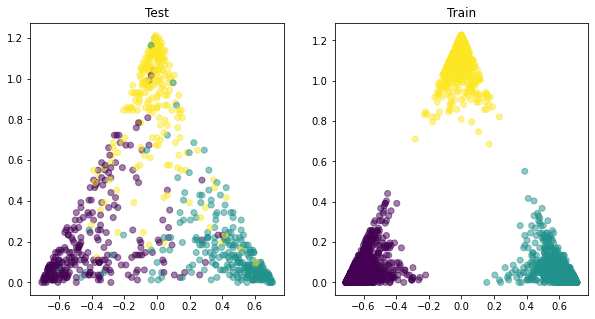

In [571]:
y_probs_rf = model.predict_proba(X_test)
y_probs_train_rf = model.predict_proba(X_train)

fig, ax = plt.subplots(ncols=2, figsize=(10,5))
plot_simplex(y_test, y_probs_rf, ax=ax[0])
plot_simplex(y_train, y_probs_train_rf, ax=ax[1])
ax[0].set_title("Test")
ax[1].set_title("Train")
plt.show()

In [572]:
print("AUC OVR:", round(roc_auc_score(y_test, y_probs_rf, multi_class='ovr'), 4))
print("AUC OVO:", round(roc_auc_score(y_test, y_probs_rf, multi_class='ovo'), 4))
print("GeoAUC :", round(geo_auc(y_test, y_probs_rf, metric='fisher' ), 4))
print("AUC mu :", round(auc_mu(y_test, y_probs_rf ), 4))

AUC OVR: 0.9679
AUC OVO: 0.968
GeoAUC : 0.9691
AUC mu : 0.9759


We see in this case all AUC's perform similarly.

# Toy dataset 2: imbalanced

In [579]:
X, y = make_classification(n_classes=3,
                           n_samples=10000,
                           random_state=202, 
                           n_features=8,
                           n_informative=6,
                           n_redundant=0,
                           n_repeated=0, 
                           weights=[0.1, 0.89, 0.01])

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=113)

In [580]:
np.bincount(y)

array([1030, 8847,  123])

In [581]:
model = RandomForestClassifier(random_state=8, max_depth=8, class_weight='balanced')
model.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=8, random_state=8)

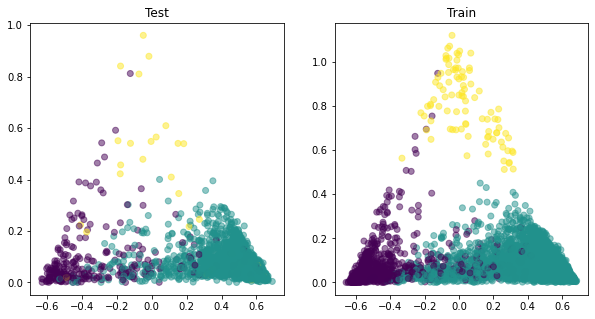

In [582]:
y_probs_rf = model.predict_proba(X_test)
y_probs_train_rf = model.predict_proba(X_train)

fig, ax = plt.subplots(ncols=2, figsize=(10,5))
plot_simplex(y_test, y_probs_rf, ax=ax[0])
plot_simplex(y_train, y_probs_train_rf, ax=ax[1])
ax[0].set_title("Test")
ax[1].set_title("Train")
plt.show()

In [583]:
print("AUC OVR:", round(roc_auc_score(y_test, y_probs_rf, multi_class='ovr'), 4))
print("AUC OVO:", round(roc_auc_score(y_test, y_probs_rf, multi_class='ovo'), 4))
print("GeoAUC :", round(geo_auc(y_test, y_probs_rf, metric='fisher' ), 4))
print("AUC mu :", round(auc_mu(y_test, y_probs_rf ), 4))

AUC OVR: 0.8851
AUC OVO: 0.8585
GeoAUC : 0.8585
AUC mu : 0.8947


# References

[1] Kleiman, Page (2019): https://proceedings.mlr.press/v97/kleiman19a.html

[2] Nielsen & Sun (2021): https://arxiv.org/pdf/1704.00454.pdf

## Appendix: Visualizing the Fisher-Hotelling-Rao metric

In [510]:
def euclidean_to_simplex(probs):
    x, y, z = probs[:,0], probs[:,1], probs[:,2]
    u = (-x+y)/np.sqrt(2)
    v = (-x-y+2*z+1)/np.sqrt(6)
    return np.array([u, v]).T

def simplex_to_euclidean(prob_2d):
    u, v = prob_2d[:,0], prob_2d[:,1]
    x = 1/2 - (u + v/np.sqrt(3))/np.sqrt(2)
    y = u/np.sqrt(2) - v/np.sqrt(6) + 1/2
    z = 1 - x - y
    return np.array([x, y, z]).T

#test
input_array = np.array([[0.1, 0.8, 0.1], [0.2, 0.5, 0.3], [1, 0, 0], [0, 1, 0]])

assert np.all(np.isclose(simplex_to_euclidean(euclidean_to_simplex(input_array)), input_array))

Let us plot a few balls in the 2D simplex $\Delta_2$, which shows up in a 3-class classification problem.

To do that, we will solve the equation $d_\mathrm{FHR}(\vec p_0, \vec p) = \epsilon$ for the variable $\vec p$. The main realization is that this equation can be solved in a few steps:

* First, removing the arccos, we have $\sum_{i=1}^K \sqrt{p_i (p_0)_i} = \cos(\epsilon/2)$. If we call 

  $$\mathbf n \equiv \sqrt{\vec p_0} \; \mbox{(element-wise)}$$
  $$\mathbf{u} \equiv \sqrt{\vec p} \; \mbox{(element-wise)}$$
  
  then the equation reduces to
  
  $$\begin{cases}
  \mathbf n \cdot \mathbf u &=  \cos   \displaystyle  \frac{\epsilon}{2} \\
  \mathbf u^2 &= 1
  \end{cases} \qquad (*)$$
  
  (we use boldface for "square-rooted" vectors as to not confuse them with "real-probability space" vectors) Notice that both $\mathbf n$ and $\mathbf u$ have unit length under the regular Euclidean norm. This will be important later on.
  

* How to solve an equation such as ($*$)? Notice that it is of the form $\mathbf a \cdot \mathbf x = b$, where $\mathbf a$ is a fixed vector and $b$ is a fixed scalar. One way is to choose a coordinate frame where the known vector $n$ is parallel to the $z$ axis. In this frame, $\mathbf n= (0,0,1)$ and the scalar product gives

  $$\cos\frac\epsilon 2 = \mathbf n \cdot \mathbf u  = |\mathbf n| |\mathbf u| \cos \theta_{n,u} = \cos \theta_{n,u}, $$
  so we find $\epsilon/2$ is just the angle between $\mathbf n$ and $\mathbf u$. Since $\mathbf n$ is just the versor in the $z$ direction, this means that the solutions $\mathbf u$ describe a cone around the $z$ axis with an angle of $\epsilon/2$ with the vertical. In spherical coordinates, this gives a family of solutions, one for each $\varphi \in [0,2\pi[$:

$$\mathbf u(\varphi)_\text{rot}
= \begin{bmatrix}
\sin \frac\epsilon 2 \cos \varphi\\
\sin \frac \epsilon 2 \sin \varphi\\
\cos \frac \epsilon 2
\end{bmatrix}
$$



* In practice, we need to be able to go back and forth between the ambient Cartesian coordinates and these where the $z$ axis is parallel to the vector $\mathbf n$. [One can show](https://math.stackexchange.com/questions/180418/calculate-rotation-matrix-to-align-vector-a-to-vector-b-in-3d) that, given two unit vectors $\mathbf a$ and $\mathbf b$, we can construct a rotation matrix $\mathbf R$ mapping $\mathbf a$ to $\mathbf b$ via:

    $$\mathbf R[\mathbf a, \mathbf b] = 1 + [\textbf v_\times] + \frac{1-c}{s^2}[\textbf v_\times]^2$$

  where, if $\mathbf v = \mathbf a \times \mathbf b$, then
  * $c = \mathbf a \cdot \mathbf b$ is the cosine;
  * $s = |\mathbf v|$ is the sine;
  * $[\textbf v_\times]$ is the 3x3 matrix such that for all vector $\textbf u$, $[\textbf v_\times] \mathbf u = \mathbf v \times \mathbf u$. In coordinates,

    $$[\textbf v_\times] = \begin{bmatrix}
        0 & -v_z &  v_y\\
        v_z & 0 & -v_x\\
        -v_y & v_x & 0
        \end{bmatrix}$$
        
We need then just create the matrix $\mathbf R[\mathbf n, \mathbf e_z]$ that maps $\mathbf n$ into the $z$-axis.

* We apply $\mathbf R[\mathbf n, \mathbf e_z]$ on $\mathbf u(\varphi)_\text{rot}$ to go back to original coordinates
* Finally, we square in order to retrieve probabilities.

Our final expression for the ball will be

$$\vec p(\varphi) = (\mathbf R[\mathbf n, \mathbf e_z] \mathbf u(\varphi)_\text{rot})^2\; \mbox{(element-wise)}$$

We implement this procedure below:

In [527]:
def rot_matrix_a2b(a, b):
    assert a.shape == b.shape
    assert np.abs(np.linalg.norm(a) - 1) < 1e-5
    assert np.abs(np.linalg.norm(b) - 1) < 1e-5
    
    v = np.cross(a,b)
    s = np.linalg.norm(v)
    c = np.dot(a,b)
    
    v_cross = np.array([
        [0, -v[2], v[1]],
        [v[2], 0, -v[0]],
        [-v[1], v[0], 0]
    ])
    
    R = np.eye(len(a)) + v_cross + (1-c)/(s**2) * np.dot(v_cross, v_cross)
    return R

#teste
a = np.array([1,2,3]); b = np.array([9,4,5])
a, b = a/np.linalg.norm(a), b/np.linalg.norm(b)
rot = rot_matrix_a2b(a,b)
assert np.all(np.isclose(rot@a, b))

def rotation_function_from_3d_prob_vector(p0):

    assert p0.shape == (3,), "Invalid shape for p0"
    assert p0.sum() == 1, "p0 not valid probability vector"

    n = np.sqrt(p0)
    k = np.array([0,0,1])
    Q = rot_matrix_a2b(n, k)
    def rotate_back(vec):
        return Q@vec
    
    return rotate_back

In [528]:
    
def fhr_ball(p0, r, circle_steps=4):
    
    # creating circle
    phi = np.linspace(0, 2*np.pi, circle_steps)
    eps_over_2 = 0.5*r*np.ones_like(phi)
    
    # to avoid numerical issues with large angles, we will need some cuts
#     eps_over_2 = np.clip(eps_over_2, 0, np.pi/2)
    
    points = np.array([np.sin(eps_over_2)*np.cos(phi),
                       np.sin(eps_over_2)*np.sin(phi), 
                       np.cos(eps_over_2)]).T
    
    
    transform = rotation_function_from_3d_prob_vector(p0)

    euclidean = np.array([transform(point) for point in points])

#     fig = plt.figure()
#     ax = plt.axes(projection='3d')

#     ax.scatter3D(euclidean[:,0], euclidean[:,1], euclidean[:,2])
#     plt.show()
    
    euclidean = np.abs(euclidean)**2.0 # pra voltar a serem probabilidades

    return euclidean, transform

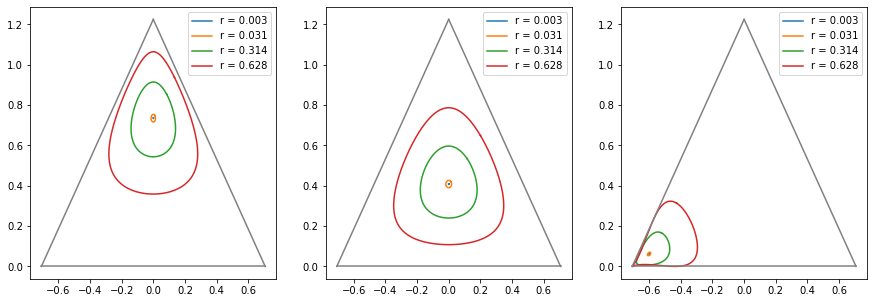

In [529]:
def plot_balls(p0, radii, ax):
    assert p0.shape == (3,), "Invalid shape for p0"
    assert p0.sum() == 1, "p0 not valid probability vector"

    for r in radii:
        ball, transform = fhr_ball(p0, r=r, circle_steps=500)
        ball_simplex = euclidean_to_simplex(ball)
        ax.plot(ball_simplex[:,0], ball_simplex[:,1], label=f"r = {round(r,3)}")

    ax.plot([-1/np.sqrt(2), 0], [0, np.sqrt(3/2)], color='gray')
    ax.plot([0, 1/np.sqrt(2) ], [np.sqrt(3/2), 0], color='gray')
    ax.plot([-1/np.sqrt(2), 1/np.sqrt(2)], [0, 0], color='gray')
    ax.legend()
    
    return ball, ball_simplex
    
radii = np.pi/np.array([1000, 100, 10, 5])

fig, ax = plt.subplots(figsize=(15,5), ncols=3)
plot_balls(p0=np.array([0.2, 0.2, 0.6]), radii=radii, ax=ax[0])
plot_balls(p0=np.array([0.3333, 0.3333, 0.3334]), radii=radii, ax=ax[1])
ball, ball_simplex = plot_balls(p0=np.array([0.90, 0.05, 0.05]), radii=radii, ax=ax[2])
plt.show()

### Are some of the weird results (for large radius) due to numerical instabilities? Or some actual error in calculations?

Let us study the case in one dimension:

Fix $p_0$. The equation for the ball is 
$$2 \cos^{-1}( \sqrt{p_0 p} + \sqrt{(1-p_0)(1-p)}) = \epsilon$$

To solve this, define $\theta_0, \theta$ such that

$$p_0 = \sin^2 \theta_0, \quad p = \sin^2 \theta.$$

We assume with no loss of generality that $\theta_0$ is in $[0,\pi/2]$.

Then 

$$\sqrt{p_0 p} + \sqrt{(1-p_0)(1-p)} = \cos \theta_0 \cos \theta + \sin \theta_0 \sin \theta = \cos(\theta-\theta_0)$$

which must be equal to $\cos \epsilon/2$; but

$$\cos x = \cos a \quad \Rightarrow \quad x = 
\begin{cases} a + 2k \pi\\
\quad\mbox{or}\\
- a + 2k \pi
\end{cases}$$

from which we get
$$\theta-\theta_0 = \pm \frac{\epsilon}{2} + 2k \pi \Rightarrow\quad \theta = \theta_0 \pm \frac{\epsilon}{2} + 2k\pi, \quad k \in \mathbb Z$$

Now, we can with no loss of generality assume $\theta \in [0,\pi/2]$; hence we can only take the $k=0$ set of solutions. Hence, we can keep both $\pm$ values as long as they don't escape this interval; in other words

$$\boxed{\theta(\theta_0, \epsilon) = \mathrm{cap}\left( \theta_0 \pm \frac \epsilon 2; \mbox{low}=0; \mbox{high} = \frac \pi 2\right)}$$

To rewrite this in terms of $p$ and $p_0$, we get a solution set

$$\boxed{p \in \{\sin^2 \theta(\theta_0, \epsilon): \;\theta_0 = \arcsin \sqrt{p_0}\}}$$

In [352]:
# Example
p_0 = 0.3
theta_0 = np.arcsin(np.sqrt(p_0))

sols = []
angles = []
eps_range = np.linspace(0.001, 2*np.pi, num=100)
for eps in eps_range:
    theta = np.array([np.clip(theta_0 + eps/2, 0, np.pi/2),
                       np.clip(theta_0 - eps/2, 0, np.pi/2)])
    p = np.sin(theta)**2
    sols.append(p)
    angles.append(theta)
    
sols = np.array(sols)

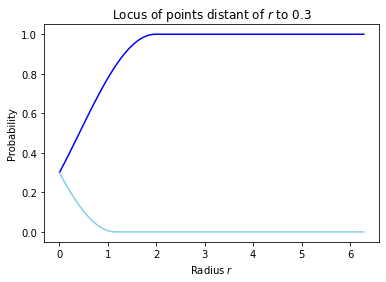

In [353]:
plt.plot(eps_range, sols[:,0], color='blue' )
plt.plot(eps_range, sols[:,1], color='skyblue')
plt.xlabel('Radius $r$')
plt.ylabel('Probability')
plt.title("Locus of points distant of $r$ to 0.3")
plt.show()

See how, as we increase the radius $\epsilon$, we eventually reach plateaus at $p=0$ and $p=1$. This is expected; we can indeed get infinitely far by only asymptotically approaching the boundaries.

**However!** Notice how a naive implementation might look like. If we handn't capped the $\theta$ value, we would have gotten instead

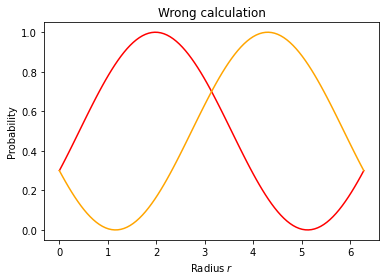

In [356]:
# Example
sols = []
angles_wrong = []
eps_range = np.linspace(0.001, 2*np.pi, num=100)
for eps in eps_range:
    theta = np.array([theta_0 + eps/2, theta_0 - eps/2])  # naive implementation
    p = np.sin(theta)**2
    sols.append(p); angles_wrong.append(theta)
    
sols = np.array(sols)

plt.plot(eps_range, sols[:,0], color='red')
plt.plot(eps_range, sols[:,1], color='orange')
plt.xlabel('Radius $r$')
plt.ylabel('Probability')
plt.title("Wrong calculation")
plt.show()

We can directly compare the theta's to see what is happening:

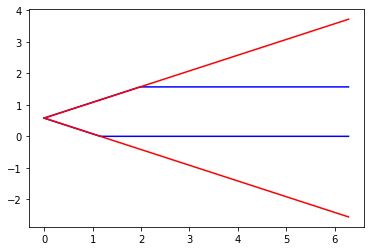

In [355]:
plt.plot(eps_range, angles, color='blue')
plt.plot(eps_range, angles_wrong, color='red')

plt.show()

The issue here is that our argument grows too much. We need to be careful with the 2D implementation too.